# Need to install an additional package

`conda install executorlib`

## Download AqSolDb v1 the first time you run:

In [1]:
# !curl https://www.amdlab.nl/database/AqSolDB/data/AqSolDB_v1.0_min.csv > AqSolDB_v1.0_min.csv

In [19]:
import pandas as pd
from tqdm import tqdm
from architector.io_obabel import get_obmol_smiles, get_OBMol_coords_anums_graph
import architector.io_ptable as io_ptable
from architector import convert_io_molecule, view_structures
from architector.io_obabel import generate_obmol_conformers
from executorlib import Executor
import numpy as np

In [20]:
df = pd.read_csv('AqSolDB_v1.0_min.csv')

In [21]:
df

,ID,Name,InChIKey,SMILES,Solubility
0,A-3,"N,N,N-trimethyloctadecan-1-aminium bromide",SZEMGTQCPRNXEG-UHFFFAOYSA-M,[Br-].CCCCCCCCCCCCCCCCCC[N+](C)(C)C,-3.616127
1,A-4,Benzo[cd]indol-2(1H)-one,GPYLCFQEKPUWLD-UHFFFAOYSA-N,O=C1Nc2cccc3cccc1c23,-3.254767
2,A-5,4-chlorobenzaldehyde,AVPYQKSLYISFPO-UHFFFAOYSA-N,Clc1ccc(C=O)cc1,-2.177078
3,A-8,"zinc bis[2-hydroxy-3,5-bis(1-phenylethyl)benzo...",XTUPUYCJWKHGSW-UHFFFAOYSA-L,[Zn++].CC(c1ccccc1)c2cc(C(C)c3ccccc3)c(O)c(c2)...,-3.924409
4,A-9,4-({4-[bis(oxiran-2-ylmethyl)amino]phenyl}meth...,FAUAZXVRLVIARB-UHFFFAOYSA-N,C1OC1CN(CC2CO2)c3ccc(Cc4ccc(cc4)N(CC5CO5)CC6CO...,-4.662065
...,...,...,...,...,...
9977,I-84,tetracaine,GKCBAIGFKIBETG-UHFFFAOYSA-N,C(c1ccc(cc1)NCCCC)(=O)OCCN(C)C,-3.010000
9978,I-85,tetracycline,OFVLGDICTFRJMM-WESIUVDSSA-N,OC1=C(C(C2=C(O)[C@@](C(C(C(N)=O)=C(O)[C@H]3N(C...,-2.930000
9979,I-86,thymol,MGSRCZKZVOBKFT-UHFFFAOYSA-N,c1(cc(ccc1C(C)C)C)O,-2.190000
9980,I-93,verapamil,SGTNSNPWRIOYBX-UHFFFAOYSA-N,COc1ccc(CCN(C)CCCC(C#N)(C(C)C)c2ccc(OC)c(OC)c2...,-3.980000


In [22]:
f1 = (df.SMILES.str.count('\.') < 1) # Remove any disjoint components

In [23]:
f2 = pd.Series([True]*df.shape[0])
for i,row in tqdm(df.iterrows(), total=df.shape[0]):
    obmol = get_obmol_smiles(row['SMILES'], build=False)
    _ , syms, _  = get_OBMol_coords_anums_graph(obmol, get_types=True)
    mets = [x for x in syms if x in io_ptable.all_metals]
    if len(mets) > 0:
        f2[i] = False

100%|██████████| 9982/9982 [00:03<00:00, 2985.68it/s]


In [24]:
fdf = df[(f2) & (f1)]
print(fdf.shape)

(8797, 5)


In [8]:
def gen_confs(smi, totaln=50):
    inmol = convert_io_molecule(smi)
    confs, energies = generate_obmol_conformers(inmol, return_energies=True, conf_cutoff=totaln*100)
    energies = np.array(energies)
    confs = np.array(confs)
    inds = np.argsort(energies)[0:totaln]
    energies = energies[inds]
    confs = confs[inds]
    out_confs = []
    for i,conf in enumerate(confs):
        tmol = convert_io_molecule(conf)
        tmol.charge = inmol.charge
        tmol.uhf = 0
        tmol.xtb_charge = inmol.charge
        tmol.xtb_uhf = 0
        tconf = tmol.write_mol2('UFF_Energy={}'.format(energies[i]), writestring=True)
        out_confs.append(tconf)
    return out_confs

In [9]:
confs = gen_confs('[O-]CCCCC')

..tot conformations = 27
..tot confs tested = 27
..below energy threshold = 24


In [10]:
view_structures(confs[0:10])

3Dmol.js failed to load for some reason. Please check your browser console for error messages.

In [11]:
len(confs)

25

In [12]:
print(confs[0])

@<TRIPOS>MOLECULE
UFF_Energy=0.18387233505621525 Charge: -1 Unpaired_Electrons: 0 XTB_Unpaired_Electrons: 0 XTB_Charge: -1
    17    16     1     0     0
SMALL
NoCharges
****
Generated from Architector

@<TRIPOS>ATOM
     1 O1        2.5957    2.3900    1.1867   O.3       1 RES1   0.0000
     2 C1        2.2034    1.4242    2.0047   C.3       1 RES1   0.0000
     3 C2        2.7363    0.0752    1.4492   C.3       1 RES1   0.0000
     4 C3        2.3843   -1.1815    2.2648   C.3       1 RES1   0.0000
     5 C4        2.9167   -2.5023    1.7041   C.3       1 RES1   0.0000
     6 C5        2.5410   -3.7117    2.5470   C.3       1 RES1   0.0000
     7 H1        2.5089    1.4664    3.0600   H         1 RES1   0.0000
     8 H2        1.1186    1.2647    2.1157   H         1 RES1   0.0000
     9 H3        2.3437   -0.0502    0.4308   H         1 RES1   0.0000
    10 H4        3.8288    0.1191    1.3326   H         1 RES1   0.0000
    11 H5        2.7709   -1.0483    3.2831   H         1 RES1 

In [13]:
ind = 12
confs = gen_confs(fdf.iloc[ind]['SMILES'])
print('Confomers:', len(confs))
view_structures(fdf.iloc[ind]['SMILES'])
view_structures(confs[0:4])

..tot conformations = 5184
..tot confs tested = 5000
..below energy threshold = 2597
Confomers: 50


3Dmol.js failed to load for some reason. Please check your browser console for error messages.

3Dmol.js failed to load for some reason. Please check your browser console for error messages.

In [14]:
def evalulate_conf_xtb(conf):
    import os
    os.environ["OMP_NUM_THREADS"] = "1"
    os.environ["OPENBLAS_NUM_THREADS"] = "1"
    os.environ["MKL_NUM_THREADS"] = "1"
    os.environ["VECLIB_MAXIMUM_THREADS"] = "1"
    os.environ["NUMEXPR_NUM_THREADS"] = "1"
    from architector.io_calc import CalcExecutor
    from xtb_solvent import xtb_solv_params
    solvent='water'
    out = CalcExecutor(conf,
                       method='GFN2-xTB',
                       store_results=True,
                       relax=True,
                       fmax=0.05,
                       xtb_solvent=solvent)
    if out.successful:
        results = out.results
        results['xtb_mol2'] = out.mol.write_mol2('GFn2-XTB_relax', 
                                                  writestring=True)
        xtb_sa_eval_dict = xtb_solv_params(results['xtb_mol2'], solvent=solvent)
        if isinstance(xtb_sa_eval_dict, dict):
            results.update(xtb_sa_eval_dict)
        else:
            return None
        return results
    else:
        return None

In [15]:
out = evalulate_conf_xtb(confs[0])

In [16]:
out.keys()

dict_keys(['energy', 'free_energy', 'forces', 'dipole', 'charges', 'xtb_mol2', 'sas', 'born_radii'])

In [39]:
with Executor(max_workers=12, cores_per_worker=1, threads_per_core=1,
              hostname_localhost=True,# Needed on Mac only
              block_allocation=True) as exe:
    out_results = list(tqdm(exe.map(evalulate_conf_xtb, confs), total=len(confs)))

100%|██████████| 50/50 [00:07<00:00,  6.74it/s]


In [32]:
def full_conf_xtb_workflow(insmiles):
    import os
    os.environ["OMP_NUM_THREADS"] = "1"
    os.environ["OPENBLAS_NUM_THREADS"] = "1"
    os.environ["MKL_NUM_THREADS"] = "1"
    os.environ["VECLIB_MAXIMUM_THREADS"] = "1"
    os.environ["NUMEXPR_NUM_THREADS"] = "1"
    from architector.io_calc import CalcExecutor
    from architector import convert_io_molecule
    from architector.io_obabel import generate_obmol_conformers
    from xtb_solvent import xtb_solv_params
    solvent = 'water'
    totaln = 50
    def gen_confs(smi):
        inmol = convert_io_molecule(smi)
        confs, energies = generate_obmol_conformers(inmol,
                                                    return_energies=True,
                                                    conf_cutoff=totaln*100)
        energies = np.array(energies)
        confs = np.array(confs)
        inds = np.argsort(energies)[0:totaln]
        energies = energies[inds]
        confs = confs[inds]
        out_confs = []
        for i,conf in enumerate(confs):
            tmol = convert_io_molecule(conf)
            tmol.charge = inmol.charge
            tmol.uhf = 0
            tmol.xtb_charge = inmol.charge
            tmol.xtb_uhf = 0
            tconf = tmol.write_mol2('UFF_Energy={}'.format(energies[i]), writestring=True)
            out_confs.append(tconf)
        return out_confs
    confs = gen_confs(insmiles)
    results_list = []
    for conf in confs:
        try:
            out = CalcExecutor(conf,
                               method='GFN2-xTB',
                               store_results=True,
                               relax=True,
                               fmax=0.05,
                               xtb_solvent=solvent)
            if out.successful:
                results = out.results
                results['xtb_mol2'] = out.mol.write_mol2('GFn2-XTB_relax', 
                                                         writestring=True)
                results['uff_energy'] = float(conf.split('\n')[1].split('=')[1].split()[0])
                results['uff_mol2'] = conf
                results['smiles'] = insmiles
                results['total_charge'] = out.mol.charge
                results['total_unpaired_electrons'] = out.mol.uhf
                results['n_atoms'] = len(out.mol.ase_atoms)
                results['xtb_solvent'] = solvent
                xtb_sa_eval_dict = xtb_solv_params(results['xtb_mol2'],
                                                   solvent=solvent)
                if isinstance(xtb_sa_eval_dict, dict):
                    results.update(xtb_sa_eval_dict)
                    results['error'] = ''
                    results_list.append(results)
                else:
                    results.update({'sas':None, 'born_radii':None,
                                    'error':'XTB Sovlent Eval Error'})
                    results_list.append(results)
            else:
                results = dict()
                results['energy'] = None
                results['free_energy'] = None
                results['forces'] = None
                results['dipole'] = None
                results['charges'] = None
                results['xtb_mol'] = None
                results['uff_energy'] = float(conf.split('\n')[1].split('=')[1].split()[0])
                results['uff_mol2'] = conf
                results['smiles'] = insmiles
                results['total_charge'] = None
                results['total_unpaired_electrons'] = None
                results['n_atoms'] = None
                results['xtb_solvent'] = solvent
                results['sas'] = None
                results['born_radii'] = None
                results['error'] = 'XTB-Python Relaxation Failed'
                results_list.append(results)
        except:
            results = dict()
            results['energy'] = None
            results['free_energy'] = None
            results['forces'] = None
            results['dipole'] = None
            results['charges'] = None
            results['xtb_mol'] = None
            results['uff_energy'] = float(conf.split('\n')[1].split('=')[1].split()[0])
            results['uff_mol2'] = conf
            results['smiles'] = insmiles
            results['total_charge'] = None
            results['total_unpaired_electrons'] = None
            results['n_atoms'] = None
            results['xtb_solvent'] = solvent
            results['sas'] = None
            results['born_radii'] = None
            results['error'] = 'python/XTB error'
            results_list.append(results)
    return results_list

In [33]:
things = full_conf_xtb_workflow('[O-]CCCCCC')

..tot conformations = 81
..tot confs tested = 81
..below energy threshold = 65


<Axes: xlabel='uff_energy', ylabel='energy'>

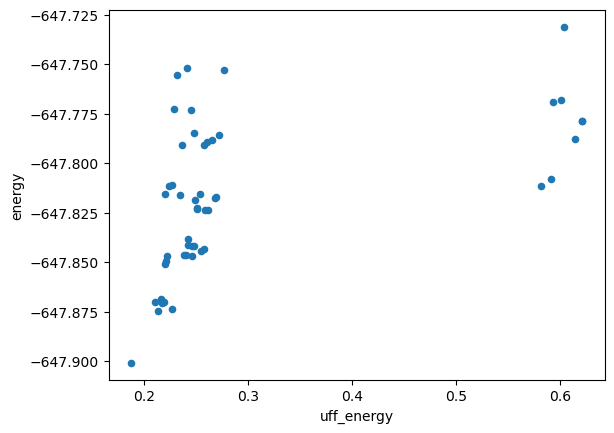

In [35]:
outdf = pd.DataFrame(things)
outdf.plot.scatter('uff_energy',
                   'energy')

In [40]:
smiles_lst = fdf.SMILES.unique()[0:24]
with Executor(max_workers=12, cores_per_worker=1, threads_per_core=1,
              hostname_localhost=True,# Needed on Mac only
                block_allocation=True) as exe:
    out_results = list(tqdm(exe.map(full_conf_xtb_workflow, smiles_lst), total=len(smiles_lst)))

  0%|          | 0/24 [00:00<?, ?it/s]

..tot conformations = 3
..tot confs tested = 3
..below energy threshold = 3
..tot conformations = 9
..tot confs tested = 9
..below energy threshold = 6
..tot conformations = 324
..tot confs tested = 324
..below energy threshold = 237
..tot conformations = 8
..tot confs tested = 8
..below energy threshold = 8
..tot conformations = 9
..tot confs tested = 9
..below energy threshold = 9
..tot conformations = 544195584
..tot conformations = 450
..tot confs tested = 450
..below energy threshold = 302
..tot conformations = 2916
..tot confs tested = 2916
..below energy threshold = 1617
..tot conformations = 216
..tot confs tested = 216
..below energy threshold = 145
..tot conformations = 144
..tot confs tested = 144
..below energy threshold = 107
..tot confs tested = 5000
..below energy threshold = 154
..tot conformations = 4100625


  4%|▍         | 1/24 [00:02<00:55,  2.40s/it]

..tot confs tested = 5000
..below energy threshold = 3577
..tot conformations = 5184
..tot confs tested = 5000
..below energy threshold = 2590


  8%|▊         | 2/24 [00:02<00:26,  1.21s/it]

..tot conformations = 864
..tot confs tested = 864
..below energy threshold = 146
..tot conformations = 1
..tot confs tested = 1
..below energy threshold = 1
..tot conformations = 72900
..tot conformations = 218700
..tot confs tested = 5000
..below energy threshold = 1360
..tot confs tested = 5000
..below energy threshold = 1373
..tot conformations = 324
..tot confs tested = 324
..below energy threshold = 195
..tot conformations = 12
..tot confs tested = 12
..below energy threshold = 11
..tot conformations = 17714700
..tot confs tested = 5000
..below energy threshold = 785
..tot conformations = 16200
..tot confs tested = 5000
..below energy threshold = 2873


100%|██████████| 24/24 [07:26<00:00, 18.61s/it]  


In [41]:
combined_df = pd.concat([pd.DataFrame(x) for x in out_results])

In [42]:
combined_df

,energy,free_energy,forces,dipole,charges,xtb_mol2,uff_energy,uff_mol2,smiles,total_charge,total_unpaired_electrons,n_atoms,xtb_solvent,sas,born_radii,error
0,-928.987146,-928.987146,"[[0.029674613590476094, 0.03069614777792387, 0...","[1.168339910989748, -0.01081207339530312, -0.0...","[-0.49797411297600425, 0.2786329782305895, -0....",@<TRIPOS>MOLECULE\nGFn2-XTB_relax Charge: 0 Un...,1.589160,@<TRIPOS>MOLECULE\nUFF_Energy=1.58915988409507...,O=C1Nc2cccc3cccc1c23,0.0,0,20,water,"[32.747, 9.297, 4.594, 6.598, 9.554, 9.219, 9....","[2.048, 2.516, 2.361, 2.779, 2.527, 2.498, 2.5...",
0,-711.011396,-711.011396,"[[0.03271440880954278, 0.00881394930981415, -0...","[-0.44184007626667393, 0.478190351625017, -0.0...","[-0.17711887761378148, 0.11387993147269006, -0...",@<TRIPOS>MOLECULE\nGFn2-XTB_relax Charge: 0 Un...,1.306293,@<TRIPOS>MOLECULE\nUFF_Energy=1.30629335189420...,Clc1ccc(C=O)cc1,0.0,0,14,water,"[53.261, 5.451, 8.98, 8.892, 5.559, 12.215, 30...","[2.453, 2.629, 2.532, 2.532, 2.58, 2.343, 2.00...",
1,-711.011395,-711.011395,"[[0.032709569054735946, 0.008817563462693042, ...","[-0.44179901068812616, 0.47819194098909434, -0...","[-0.17711886923164494, 0.11387999360970781, -0...",@<TRIPOS>MOLECULE\nGFn2-XTB_relax Charge: 0 Un...,1.306295,@<TRIPOS>MOLECULE\nUFF_Energy=1.30629501797116...,Clc1ccc(C=O)cc1,0.0,0,14,water,"[53.261, 5.451, 8.98, 8.893, 5.559, 12.215, 30...","[2.453, 2.629, 2.532, 2.532, 2.58, 2.343, 2.00...",
0,-2472.352796,-2472.352796,"[[-0.003666031123354649, 0.01277247014516381, ...","[-0.4972791660814935, 0.06002550781758898, 0.2...","[0.059424156705101774, -0.36087324676539795, 0...",@<TRIPOS>MOLECULE\nGFn2-XTB_relax Charge: 0 Un...,5.168385,@<TRIPOS>MOLECULE\nUFF_Energy=5.16838501575429...,C1OC1CN(CC2CO2)c3ccc(Cc4ccc(cc4)N(CC5CO5)CC6CO...,0.0,0,61,water,"[4.655, 23.314, 1.141, 0.22, 0.221, 1.092, 1.5...","[2.299, 2.102, 2.426, 2.542, 2.595, 2.521, 2.4...",
1,-2472.196491,-2472.196491,"[[-0.006819082370494361, -0.01203529343689437,...","[-0.5562871701997282, -0.32305525040381583, -0...","[0.06057138982854218, -0.3567195675461228, 0.1...",@<TRIPOS>MOLECULE\nGFn2-XTB_relax Charge: 0 Un...,6.604111,@<TRIPOS>MOLECULE\nUFF_Energy=6.60411099887857...,C1OC1CN(CC2CO2)c3ccc(Cc4ccc(cc4)N(CC5CO5)CC6CO...,0.0,0,61,water,"[5.566, 23.432, 1.285, 0.474, 0.0, 0.532, 1.48...","[2.311, 2.105, 2.421, 2.541, 2.62, 2.544, 2.42...",
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45,-1138.613290,-1138.613290,"[[-0.008372803870431059, 0.002736921601668405,...","[-0.2793258562272732, -0.43837586352097835, -0...","[-0.06389467574691424, -0.06601906306889059, 0...",@<TRIPOS>MOLECULE\nGFn2-XTB_relax Charge: 0 Un...,1.562052,@<TRIPOS>MOLECULE\nUFF_Energy=1.56205236203637...,C=CC(=O)OCCOc1ccccc1,0.0,0,26,water,"[14.711, 8.732, 4.553, 13.744, 8.291, 1.647, 1...","[2.284, 2.335, 2.384, 2.073, 2.186, 2.344, 2.3...",
46,-1138.459457,-1138.459457,"[[-0.0034355082535056825, 0.001357204995311869...","[-0.1250093670284649, 0.20232137218604318, -0....","[-0.0634279751025087, -0.06560212042837775, 0....",@<TRIPOS>MOLECULE\nGFn2-XTB_relax Charge: 0 Un...,1.562707,@<TRIPOS>MOLECULE\nUFF_Energy=1.56270725795430...,C=CC(=O)OCCOc1ccccc1,0.0,0,26,water,"[14.758, 9.295, 6.596, 20.33, 8.262, 1.651, 0....","[2.278, 2.326, 2.359, 2.034, 2.168, 2.319, 2.3...",
47,-1138.470153,-1138.470153,"[[-0.005259660046312267, -0.006675876074617108...","[-0.41737257411772066, -0.6509920978150671, 0....","[-0.06677415651837924, -0.06385814053344976, 0...",@<TRIPOS>MOLECULE\nGFn2-XTB_relax Charge: 0 Un...,1.562777,@<TRIPOS>MOLECULE\nUFF_Energy=1.56277712236174...,C=CC(=O)OCCOc1ccccc1,0.0,0,26,water,"[14.67, 9.319, 6.565, 24.607, 3.911, 1.258, 0....","[2.28, 2.326, 2.354, 2.022, 2.188, 2.326, 2.34...",
48,-1138.531800,-1138.531800,"[[-0.020111039918423425, 0.03796640643233803, ...","[0.004217809030666135, 0.4534882318071686, -0....","[-0.06486176258665638, -0.0657872016692648, 0....",@<TRIPOS>MOLECULE\nGFn2-XTB_relax Charge: 0 Un...,1.563417,@<TRIPOS>MOLEC

In [86]:
# from concurrent.futures import ProcessPoolExecutor
# import multiprocessing as mp

In [87]:
# with ProcessPoolExecutor(
#     max_workers=12,
#     mp_context=mp.get_context('fork')) as exe:
#     out_results = list(tqdm(exe.map(evalulate_conf_xtb, confs), total=len(confs)))

100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:04<00:00, 10.77it/s]


In [83]:
df = pd.DataFrame(out_results)

In [84]:
df

,energy,free_energy,forces,dipole,charges,xtb_mol2
0,-941.958674,-941.958674,"[[0.013625239627299732, -0.02761945714669135, ...","[0.002050091340236213, -0.5876517890028109, 0....","[-0.11474569009437266, 0.0029774315829511205, ...",@<TRIPOS>MOLECULE\nGFn2-XTB_relax Charge: 0 Un...
1,-941.996427,-941.996427,"[[-0.0053878356595929, 0.008643260340920859, -...","[-0.06075666461864399, -0.40593222294722414, 0...","[-0.11205835702754188, 0.003595081925883828, -...",@<TRIPOS>MOLECULE\nGFn2-XTB_relax Charge: 0 Un...
2,-941.971671,-941.971671,"[[-0.01630744441660046, -0.010973920097799392,...","[-0.20144515227321438, -0.5559805052449905, 0....","[-0.11414496222642409, 0.004940160692068513, -...",@<TRIPOS>MOLECULE\nGFn2-XTB_relax Charge: 0 Un...
3,-942.044609,-942.044609,"[[0.011040797441535116, 0.0049460669711957955,...","[-0.10066377134630886, -0.044639727551462866, ...","[-0.113188294205158, 0.004795871862787071, -0....",@<TRIPOS>MOLECULE\nGFn2-XTB_relax Charge: 0 Un...
4,-941.952632,-941.952632,"[[-0.000602545296799501, -0.010284753684927013...","[0.051799018924299604, -0.4568897480741798, 0....","[-0.10992971435977836, 0.005708817655650192, -...",@<TRIPOS>MOLECULE\nGFn2-XTB_relax Charge: 0 Un...
5,-941.921495,-941.921495,"[[0.002511536861121015, 0.014720142589031062, ...","[0.10106292706800629, -0.53394747862049, 0.417...","[-0.11348059196873347, 0.004868055930706369, -...",@<TRIPOS>MOLECULE\nGFn2-XTB_relax Charge: 0 Un...
6,-941.952478,-941.952478,"[[-0.00198603196646673, 0.0028855543413684338,...","[-0.25434884263964747, -0.2679091332910066, -0...","[-0.11406551220933989, 0.0031331888142655945, ...",@<TRIPOS>MOLECULE\nGFn2-XTB_relax Charge: 0 Un...
7,-941.932871,-941.932871,"[[-0.019041823948874066, 0.019897014262047423,...","[-0.07184698241635862, -0.518020087030708, 0.3...","[-0.11351759783712125, 0.004149802925545884, -...",@<TRIPOS>MOLECULE\nGFn2-XTB_relax Charge: 0 Un...
8,-941.976784,-941.976784,"[[0.0001968697982463543, 0.020288677053922004,...","[-0.33388727702051274, -0.11811975166170295, -...","[-0.11299955971356804, 0.005687126224579453, -...",@<TRIPOS>MOLECULE\nGFn2-XTB_relax Charge: 0 Un...
9,-941.922900,-941.922900,"[[-0.012029835685620039, -0.006620944241912625...","[-0.062447869421047304, -0.48126038163099577, ...","[-0.11292905760055727, 0.0035986612792885397, ...",@<TRIPOS>MOLECULE\nGFn2-XTB_relax Charge: 0 Un...


In [64]:
fdf

,ID,Name,InChIKey,SMILES,Solubility
1,A-4,Benzo[cd]indol-2(1H)-one,GPYLCFQEKPUWLD-UHFFFAOYSA-N,O=C1Nc2cccc3cccc1c23,-3.254767
2,A-5,4-chlorobenzaldehyde,AVPYQKSLYISFPO-UHFFFAOYSA-N,Clc1ccc(C=O)cc1,-2.177078
4,A-9,4-({4-[bis(oxiran-2-ylmethyl)amino]phenyl}meth...,FAUAZXVRLVIARB-UHFFFAOYSA-N,C1OC1CN(CC2CO2)c3ccc(Cc4ccc(cc4)N(CC5CO5)CC6CO...,-4.662065
5,A-10,vinyltoluene,JZHGRUMIRATHIU-UHFFFAOYSA-N,Cc1cccc(C=C)c1,-3.123150
6,A-11,3-(3-ethylcyclopentyl)propanoic acid,WVRFSLWCFASCIS-UHFFFAOYSA-N,CCC1CCC(CCC(O)=O)C1,-3.286116
...,...,...,...,...,...
9977,I-84,tetracaine,GKCBAIGFKIBETG-UHFFFAOYSA-N,C(c1ccc(cc1)NCCCC)(=O)OCCN(C)C,-3.010000
9978,I-85,tetracycline,OFVLGDICTFRJMM-WESIUVDSSA-N,OC1=C(C(C2=C(O)[C@@](C(C(C(N)=O)=C(O)[C@H]3N(C...,-2.930000
9979,I-86,thymol,MGSRCZKZVOBKFT-UHFFFAOYSA-N,c1(cc(ccc1C(C)C)C)O,-2.190000
9980,I-93,verapamil,SGTNSNPWRIOYBX-UHFFFAOYSA-N,COc1ccc(CCN(C)CCCC(C#N)(C(C)C)c2ccc(OC)c(OC)c2...,-3.980000
